## Dance move prediction using Convolutional Neural Network

#### Summary:
- no feature extraction - trained entirely on raw data
- segmentation window selected based on trial and error
- using batch_size = 36 for model training, see justifications below
- average result: ~80% accuracy after multiple hyperparameters tuning
- average result derived from 5-fold cross validation with shuffled training and test dataset

In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.neural_network as nn
import pickle
from glob import glob
from timeit import default_timer as timer
import sys
from GraphingAndTransfer.extractDataset import *

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from keras.utils import np_utils,to_categorical
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import optimizers

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
# plt.style.use('bmh')

file_path = "GraphingAndTransfer/processed/*"

pd.set_option("display.max_rows", None, "display.max_columns", None)
np.set_printoptions(threshold=10000) # 'sys.maxsize' for max

### Define segmentation window

In [2]:
NUMBER_OF_AFTER_SAMPLES = 8 #Number of samples to include in dance move after end detected
NUMBER_OF_BEFORE_SAMPLES = 8 #Number of samples to include in dance move before start detected
MINIMUM_MOVE_TIME = 20 #Minimum number of samples to be considered a move. Set this too low and you will get garbage dance samples

In [3]:
danceMoveDataset = processData(NUMBER_OF_AFTER_SAMPLES, NUMBER_OF_BEFORE_SAMPLES, MINIMUM_MOVE_TIME)

Recording from dev2 with move pointhigh at 16152387977925 opened with 685 samples
Recording from dev2 with move hair at 16152385941495 opened with 898 samples
Recording from dev2 with move dab at 16152380133389 opened with 786 samples
Recording from dev2 with move pointhigh at 16152388450418 opened with 188 samples
Recording from dev2 with move listen at 16152386837158 opened with 703 samples
Recording from dev2 with move gun at 16152384604594 opened with 903 samples
Recording from dev2 with move elbowkick at 16152382981181 opened with 1498 samples
Recording from dev2 with move sidepump at 16152389923805 opened with 754 samples
Recording from dev2 with move wipetable at 16152391069694 opened with 881 samples
Done
Extracted 87 moves from 9 raw data Sequences.
10  dab
10  elbowkick
12  gun
11  hair
12  listen
11  pointhigh
10  sidepump
11  wipetable
0  defaultMove


### Plot of each move sample with a segmentation window defined above

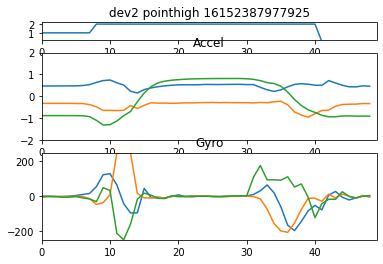

<Figure size 432x288 with 0 Axes>

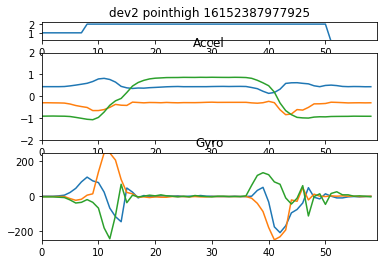

<Figure size 432x288 with 0 Axes>

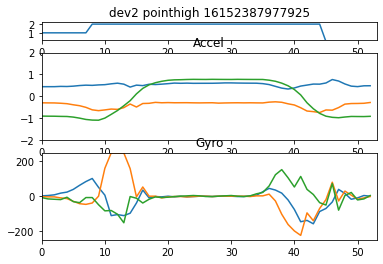

<Figure size 432x288 with 0 Axes>

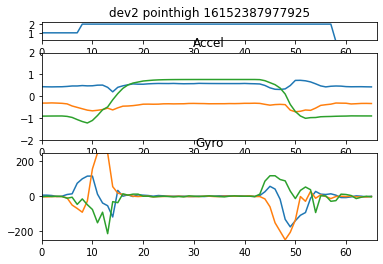

<Figure size 432x288 with 0 Axes>

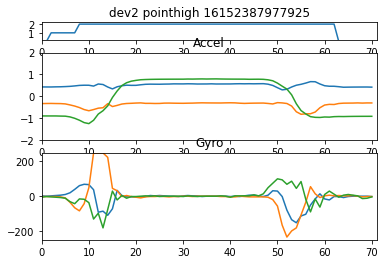

<Figure size 432x288 with 0 Axes>

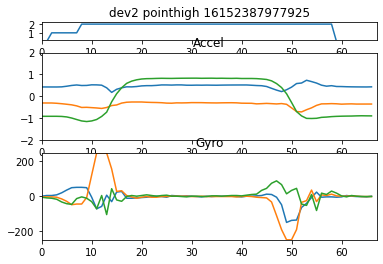

<Figure size 432x288 with 0 Axes>

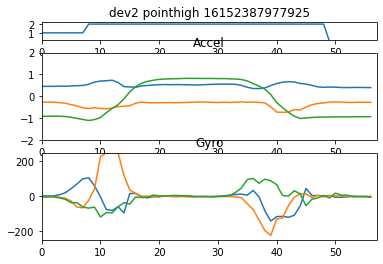

<Figure size 432x288 with 0 Axes>

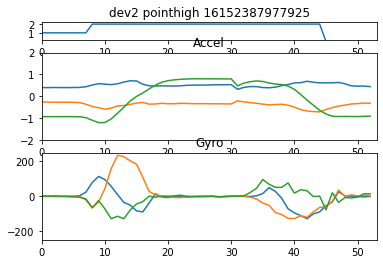

<Figure size 432x288 with 0 Axes>

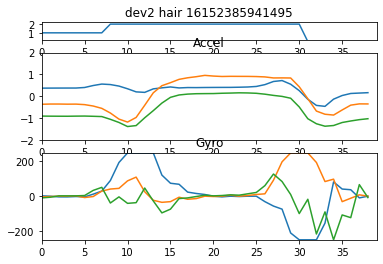

<Figure size 432x288 with 0 Axes>

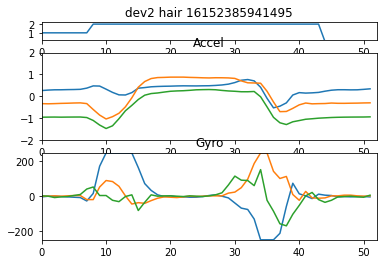

<Figure size 432x288 with 0 Axes>

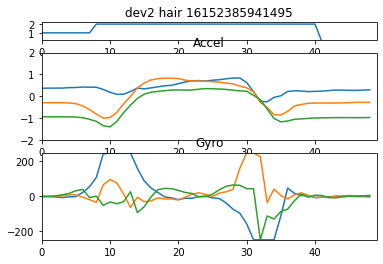

<Figure size 432x288 with 0 Axes>

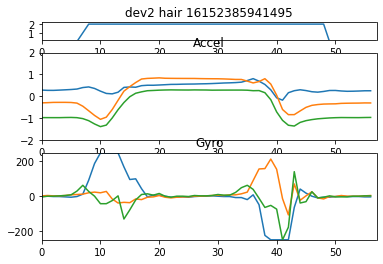

<Figure size 432x288 with 0 Axes>

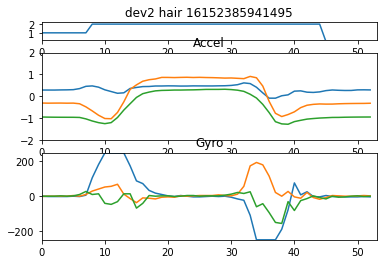

<Figure size 432x288 with 0 Axes>

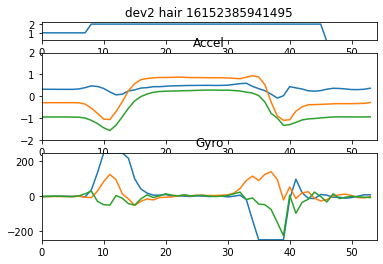

<Figure size 432x288 with 0 Axes>

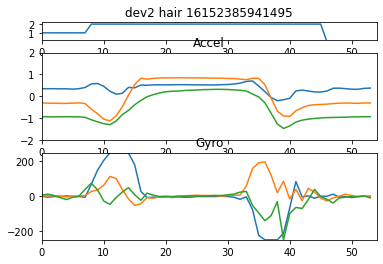

<Figure size 432x288 with 0 Axes>

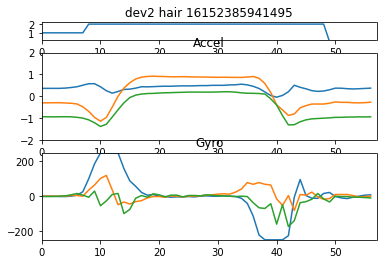

<Figure size 432x288 with 0 Axes>

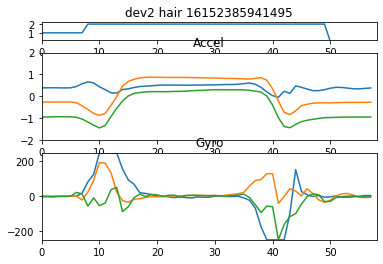

<Figure size 432x288 with 0 Axes>

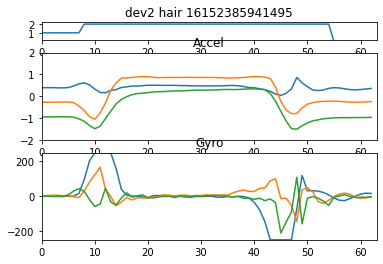

<Figure size 432x288 with 0 Axes>

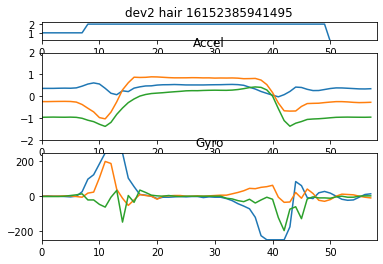

<Figure size 432x288 with 0 Axes>

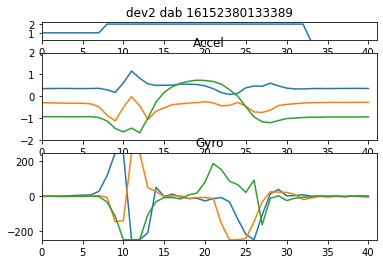

<Figure size 432x288 with 0 Axes>

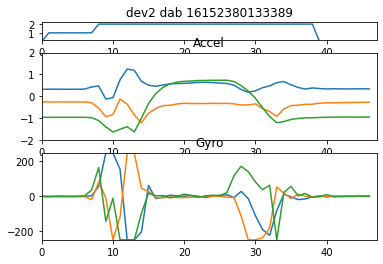

<Figure size 432x288 with 0 Axes>

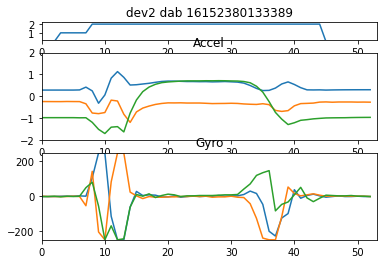

<Figure size 432x288 with 0 Axes>

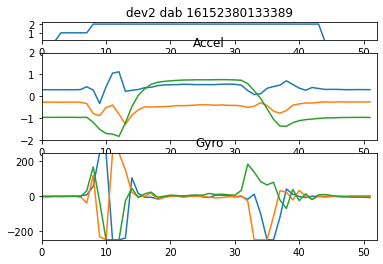

<Figure size 432x288 with 0 Axes>

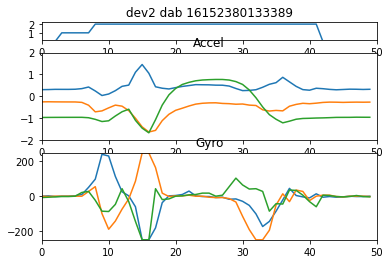

<Figure size 432x288 with 0 Axes>

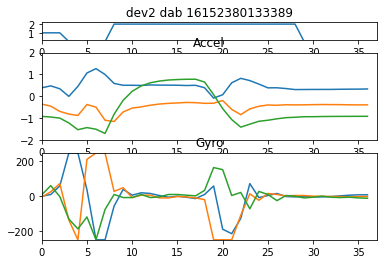

<Figure size 432x288 with 0 Axes>

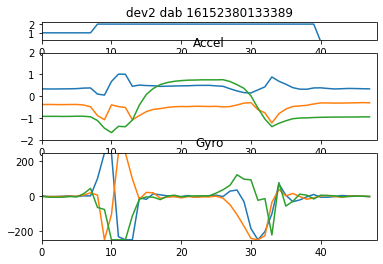

<Figure size 432x288 with 0 Axes>

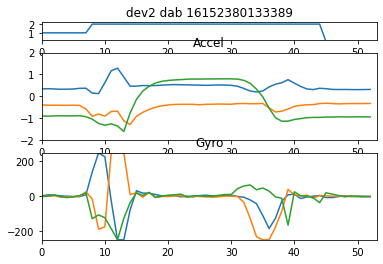

<Figure size 432x288 with 0 Axes>

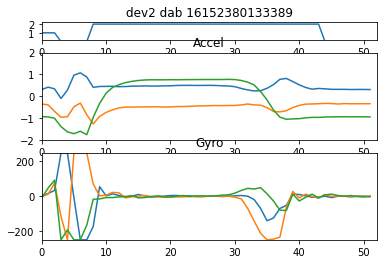

<Figure size 432x288 with 0 Axes>

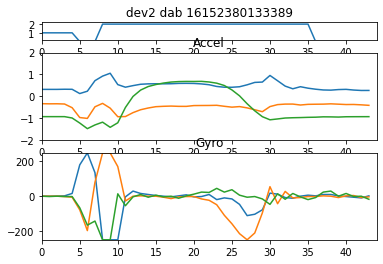

<Figure size 432x288 with 0 Axes>

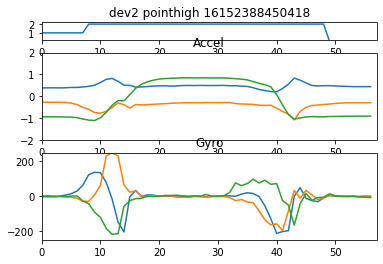

<Figure size 432x288 with 0 Axes>

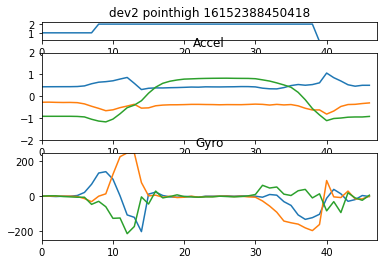

<Figure size 432x288 with 0 Axes>

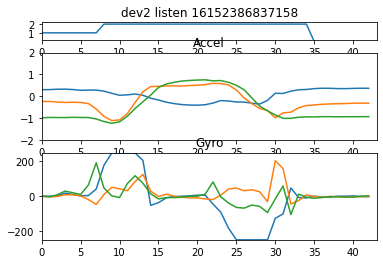

<Figure size 432x288 with 0 Axes>

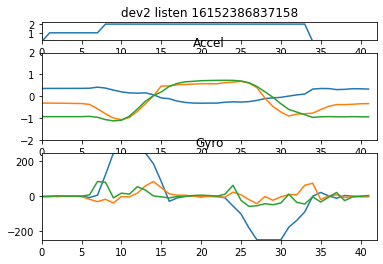

<Figure size 432x288 with 0 Axes>

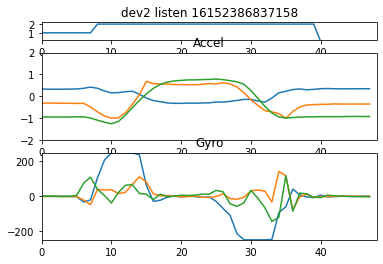

<Figure size 432x288 with 0 Axes>

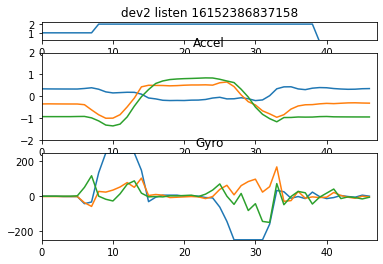

<Figure size 432x288 with 0 Axes>

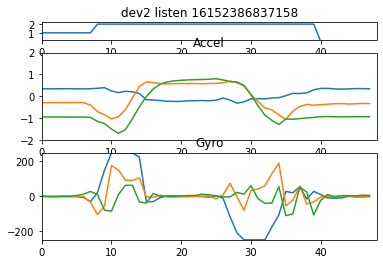

<Figure size 432x288 with 0 Axes>

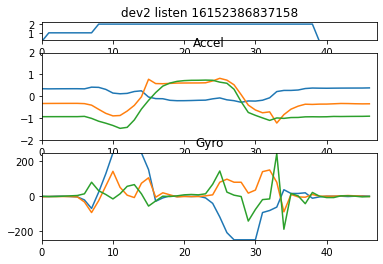

<Figure size 432x288 with 0 Axes>

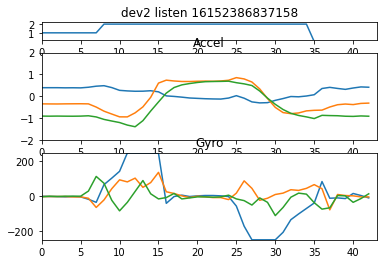

<Figure size 432x288 with 0 Axes>

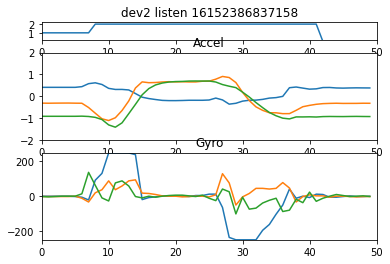

<Figure size 432x288 with 0 Axes>

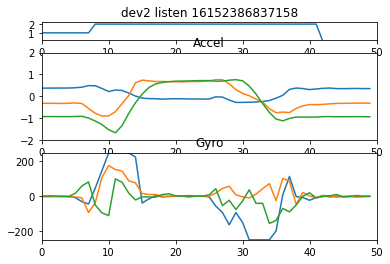

<Figure size 432x288 with 0 Axes>

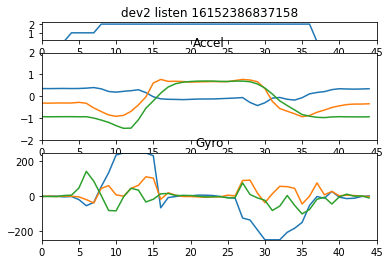

<Figure size 432x288 with 0 Axes>

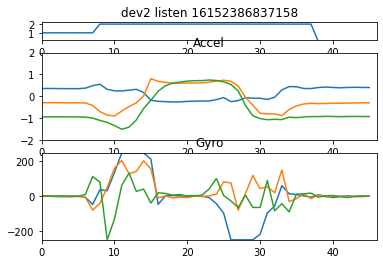

<Figure size 432x288 with 0 Axes>

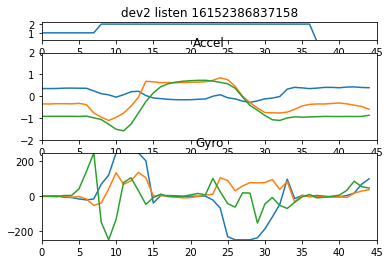

<Figure size 432x288 with 0 Axes>

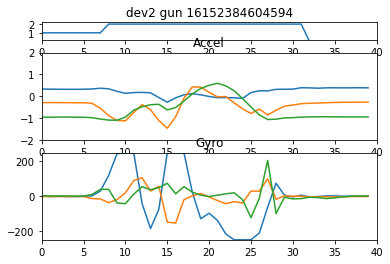

<Figure size 432x288 with 0 Axes>

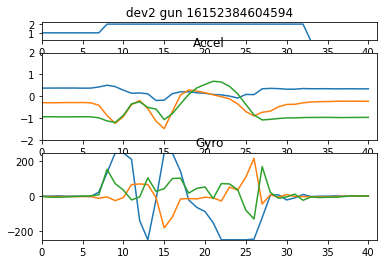

<Figure size 432x288 with 0 Axes>

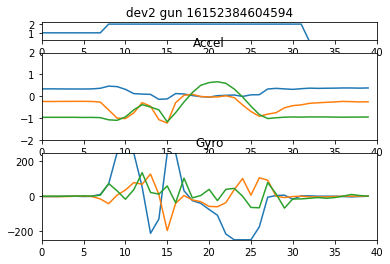

<Figure size 432x288 with 0 Axes>

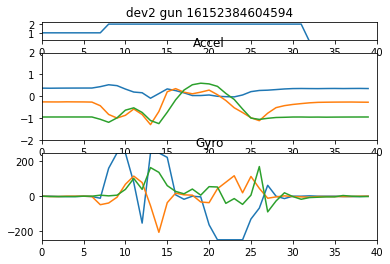

<Figure size 432x288 with 0 Axes>

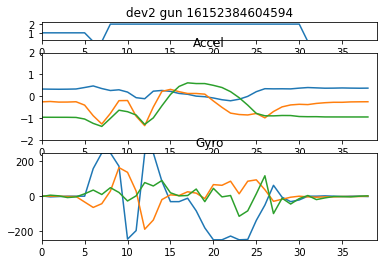

<Figure size 432x288 with 0 Axes>

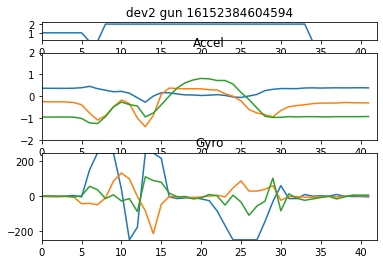

<Figure size 432x288 with 0 Axes>

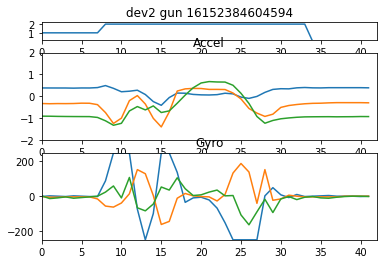

<Figure size 432x288 with 0 Axes>

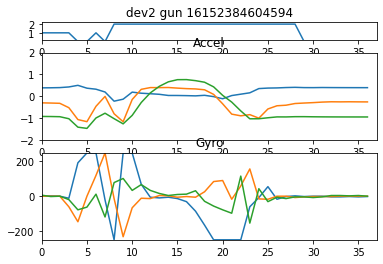

<Figure size 432x288 with 0 Axes>

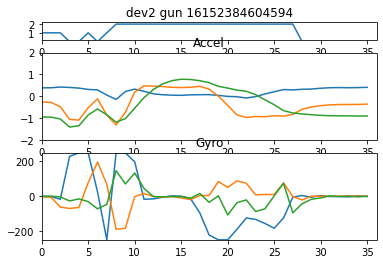

<Figure size 432x288 with 0 Axes>

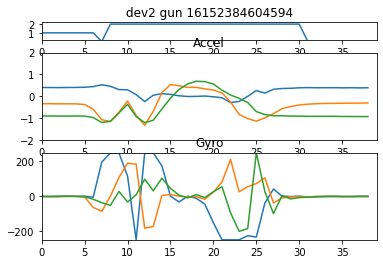

<Figure size 432x288 with 0 Axes>

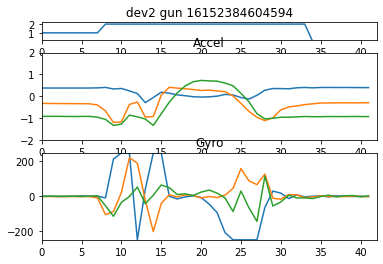

<Figure size 432x288 with 0 Axes>

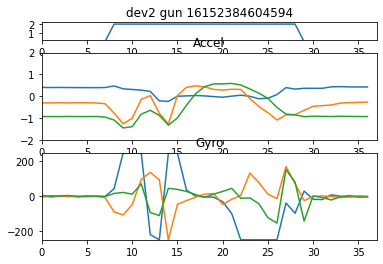

<Figure size 432x288 with 0 Axes>

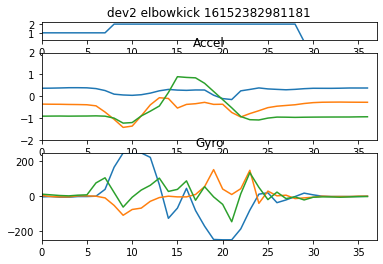

<Figure size 432x288 with 0 Axes>

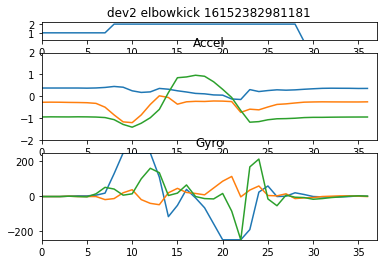

<Figure size 432x288 with 0 Axes>

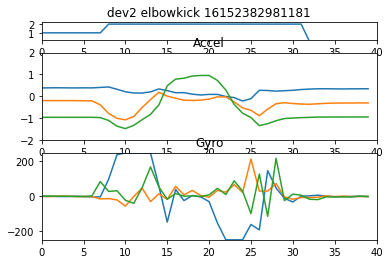

<Figure size 432x288 with 0 Axes>

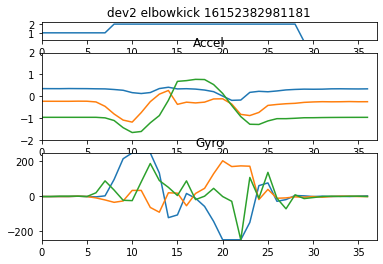

<Figure size 432x288 with 0 Axes>

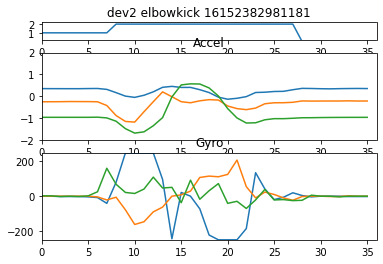

<Figure size 432x288 with 0 Axes>

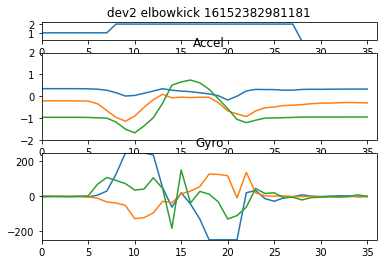

<Figure size 432x288 with 0 Axes>

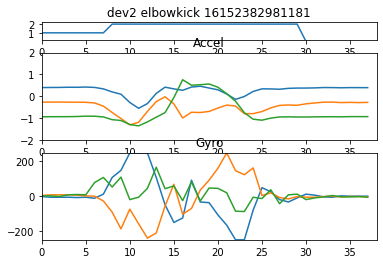

<Figure size 432x288 with 0 Axes>

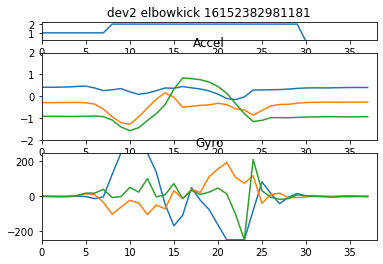

<Figure size 432x288 with 0 Axes>

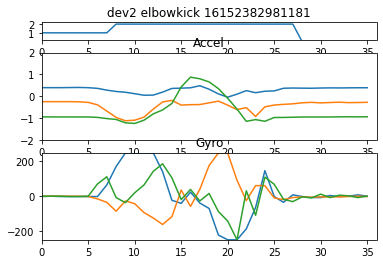

<Figure size 432x288 with 0 Axes>

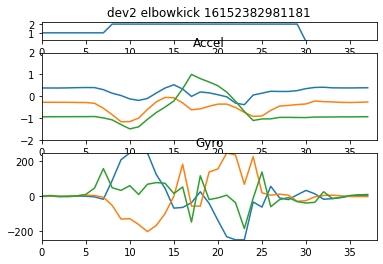

<Figure size 432x288 with 0 Axes>

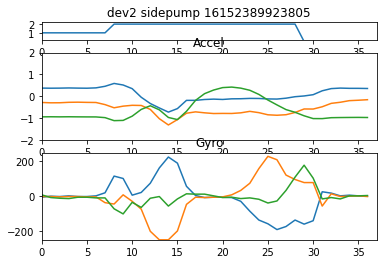

<Figure size 432x288 with 0 Axes>

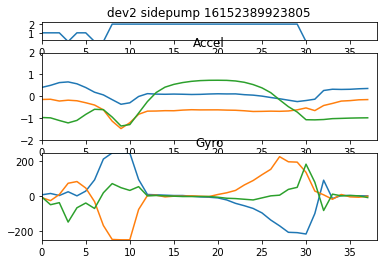

<Figure size 432x288 with 0 Axes>

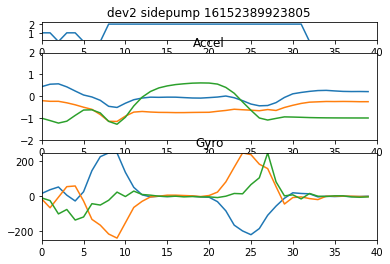

<Figure size 432x288 with 0 Axes>

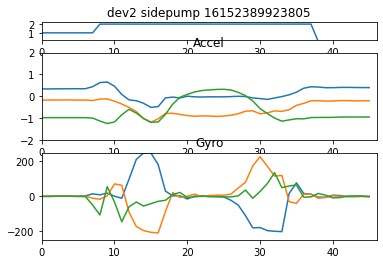

<Figure size 432x288 with 0 Axes>

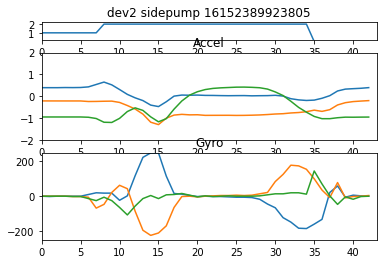

<Figure size 432x288 with 0 Axes>

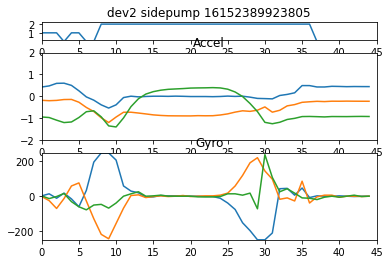

<Figure size 432x288 with 0 Axes>

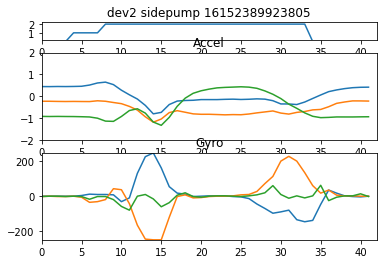

<Figure size 432x288 with 0 Axes>

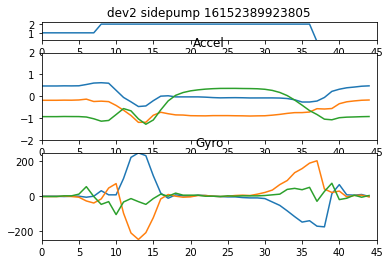

<Figure size 432x288 with 0 Axes>

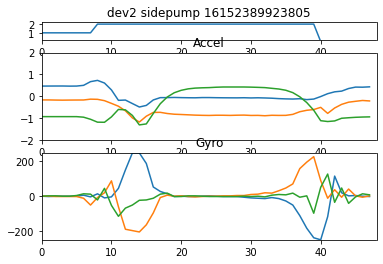

<Figure size 432x288 with 0 Axes>

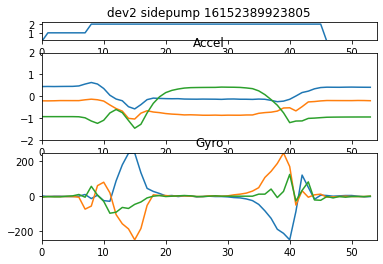

<Figure size 432x288 with 0 Axes>

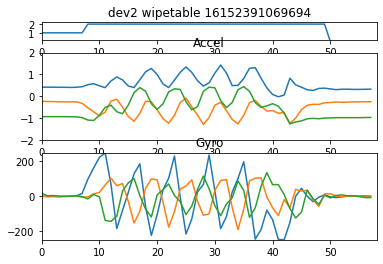

<Figure size 432x288 with 0 Axes>

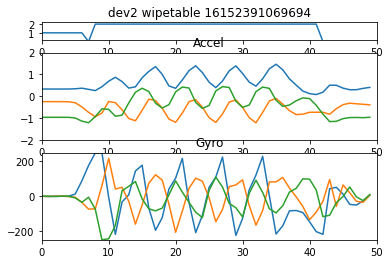

<Figure size 432x288 with 0 Axes>

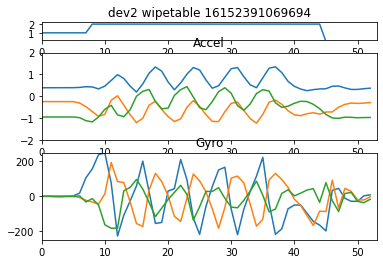

<Figure size 432x288 with 0 Axes>

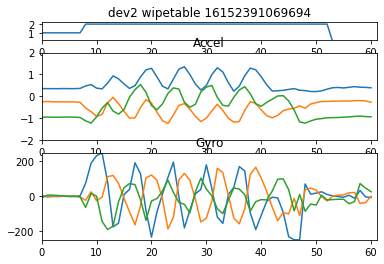

<Figure size 432x288 with 0 Axes>

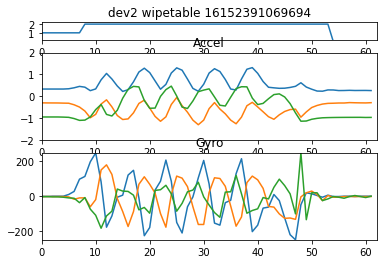

<Figure size 432x288 with 0 Axes>

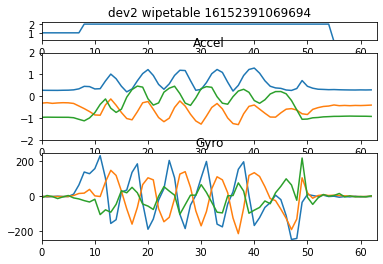

<Figure size 432x288 with 0 Axes>

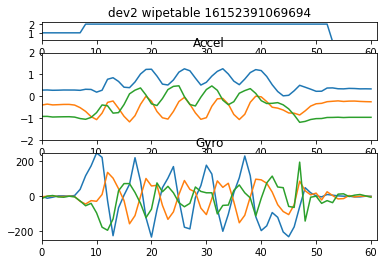

<Figure size 432x288 with 0 Axes>

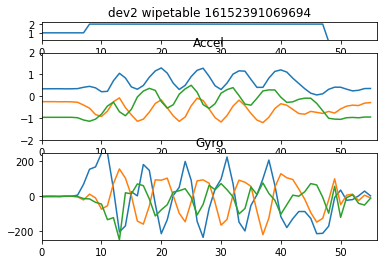

<Figure size 432x288 with 0 Axes>

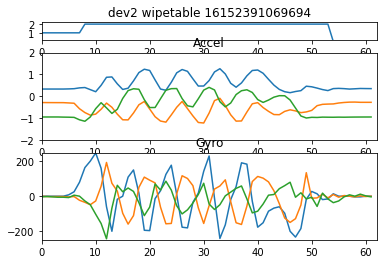

<Figure size 432x288 with 0 Axes>

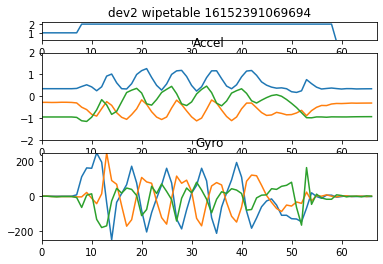

<Figure size 432x288 with 0 Axes>

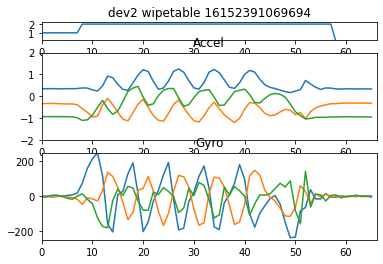

<Figure size 432x288 with 0 Axes>

In [4]:
for i in range (1, len(danceMoveDataset)):
    danceMoveDataset[i].plot()

### Number of series of samples in each move, based on the segmentation window defined above.

In [5]:
folder_path = "GraphingAndTransfer/processed/"
noOfSamples = []
for text_file in sorted(os.listdir(folder_path)):
    print("Processing:", text_file)
    
    with open(folder_path+text_file, 'r') as f:
        file = f.readlines()[1:]
    print("Number of series of samples in this move =", np.asarray(file).shape[0], "\n")
    
    noOfSamples.append(np.asarray(file).shape[0])

Processing: dev2_dab_16152380133389_19
Number of series of samples in this move = 38 

Processing: dev2_dab_16152380133389_20
Number of series of samples in this move = 41 

Processing: dev2_dab_16152380133389_21
Number of series of samples in this move = 47 

Processing: dev2_dab_16152380133389_22
Number of series of samples in this move = 53 

Processing: dev2_dab_16152380133389_23
Number of series of samples in this move = 52 

Processing: dev2_dab_16152380133389_24
Number of series of samples in this move = 50 

Processing: dev2_dab_16152380133389_25
Number of series of samples in this move = 37 

Processing: dev2_dab_16152380133389_26
Number of series of samples in this move = 48 

Processing: dev2_dab_16152380133389_27
Number of series of samples in this move = 53 

Processing: dev2_dab_16152380133389_28
Number of series of samples in this move = 52 

Processing: dev2_dab_16152380133389_29
Number of series of samples in this move = 44 

Processing: dev2_elbowkick_16152382981181_5

### Find the minimum and maximum number of samples in all captured moves

In [6]:
minSamples = min(noOfSamples)
maxSamples = max(noOfSamples)
print("Minimum: {} \nMaximum: {}" .format(minSamples, maxSamples))

Minimum: 36 
Maximum: 71


### Selecting only the first 36 series of samples in each move and append them to a dataframe in order

In [7]:
columns = ['acc_X','acc_Y','acc_Z','gyro_X','gyro_Y','gyro_Z','Stage', 'Activity']
combined_raw = pd.DataFrame(columns = columns)

In [8]:
folder_path = "GraphingAndTransfer/processed/"
for text_file in sorted(os.listdir(folder_path)):
    print("Processing:", text_file)
    
    with open(folder_path+text_file, 'r') as f:
        file = f.readlines()[1:minSamples]
        
    temp_list = []
    
    for line in file:
        temp_list.append([float(value) for value in line.split(',')])
    
    print("Shape =", np.asarray(temp_list).shape, "\n")

    # file_path_name = os.path.splitext(text_file)[0]
    # activity_labels = file_path_name.split('_')[1]

    activity_labels = text_file.split('_')[1]
        
    raw_data = np.array(temp_list)
        
    df_raw = pd.DataFrame(data = raw_data, columns = ['acc_X','acc_Y','acc_Z','gyro_X','gyro_Y','gyro_Z','Stage'])
    df_raw['Activity'] = activity_labels
    combined_raw = combined_raw.append(df_raw)

combined_raw.reset_index(drop=True, inplace=True)

Processing: dev2_dab_16152380133389_19
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_20
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_21
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_22
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_23
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_24
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_25
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_26
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_27
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_28
Shape = (35, 7) 

Processing: dev2_dab_16152380133389_29
Shape = (35, 7) 

Processing: dev2_elbowkick_16152382981181_56
Shape = (35, 7) 

Processing: dev2_elbowkick_16152382981181_57
Shape = (35, 7) 

Processing: dev2_elbowkick_16152382981181_58
Shape = (35, 7) 

Processing: dev2_elbowkick_16152382981181_59
Shape = (35, 7) 

Processing: dev2_elbowkick_16152382981181_60
Shape = (35, 7) 

Processing: dev2_elbowkick_16152382981181_61
Shape = (35, 

In [9]:
combined_raw

acc_X     acc_Y     acc_Z      gyro_X      gyro_Y      gyro_Z  Stage  \
0     0.347305 -0.299063 -0.941626   -1.953125   -1.953125    0.000000    1.0   
1     0.352133 -0.304438 -0.939976    0.000000    0.000000    0.000000    1.0   
2     0.355030 -0.313913 -0.938985    0.000000    1.953125   -1.953125    1.0   
3     0.356768 -0.319598 -0.944641    1.953125    0.000000   -1.953125    1.0   
4     0.351561 -0.323009 -0.941785    3.906250   -1.953125    0.000000    1.0   
5     0.348436 -0.325055 -0.940071    5.859375   -1.953125    0.000000    1.0   
6     0.352812 -0.351283 -0.939043    7.812500    0.000000    0.000000    1.0   
7     0.361687 -0.485770 -0.982176   27.343750    3.906250   -1.953125    1.0   
8     0.292012 -0.872712 -1.133055  117.187500   -7.812500  -33.203125    2.0   
9     0.175207 -1.136127 -1.479833  248.046875 -146.484375 -115.234375    2.0   
10    0.605124 -0.512926 -1.637900  248.046875 -140.625000 -250.000000    2.0   
11    1.156825 -0.026506 -1.463990 -250.000000  248.046875 -250.000000    2.0   
12    0.825345 -0.440903 -1.678394 -250.000000  248.046875 -250.000000    2.0   
13    0.563957 -1.064542 -1.007036 -208.984375   48.828125 -105.468750    2.0   
14    0.494624 -0.688725 -0.266722   50.781250   27.343750  -31.250000    2.0   
15    0.503024 -0.531985  0.177467   -1.953125   -3.906250   -7.812500    2.0   
16    0.508065 -0.387941  0.437730   11.718750    1.953125   -7.812500    2.0   
17    0.554839 -0.351515  0.593888   -3.906250    1.953125  -15.625000    2.0   
18    0.551653 -0.317159  0.681333  -13.671875  -13.671875    7.812500    2.0   
19    0.537242 -0.296545  0.733800  -11.718750   -7.812500   17.578125    2.0   
20    0.472345 -0.252927  0.721530  -27.343750   -7.812500   80.078125    2.0   
21    0.345907 -0.308006  0.676668  -13.671875  -11.718750  187.500000    2.0   
22    0.163794 -0.441054  0.556001   -7.812500 -156.250000  152.343750    2.0   
23    0.079527 -0.420882  0.296100  -33.203125 -250.000000   85.937500    2.0   
24    0.128966 -0.283779  0.002660 -130.859375 -250.000000   66.406250    2.0   
25    0.383630 -0.457768 -0.485904 -218.750000 -242.187500   21.484375    2.0   
26    0.467678 -0.724661 -0.954042 -250.000000 -146.484375   91.796875    2.0   
27    0.455607 -0.747296 -1.172425 -107.421875  -33.203125 -164.062500    2.0   
28    0.598364 -0.642128 -1.215955   13.671875   25.390625  -11.718750    2.0   
29    0.471518 -0.429027 -1.117073   39.062500   23.437500    1.953125    2.0   
30    0.370411 -0.376166 -1.026494    1.953125   21.484375  -25.390625    2.0   
31    0.334747 -0.344450 -1.003396    3.906250    9.765625  -11.718750    2.0   
32    0.332098 -0.312920 -0.977038    7.812500  -19.531250   -5.859375    2.0   
33    0.349259 -0.300252 -0.961223    0.000000   -9.765625   -3.906250    0.0   
34    0.353305 -0.292651 -0.964234    0.000000   -1.953125    1.953125    0.0   
35    0.347305 -0.299063 -0.941626   -1.953125   -1.953125    0.000000    1.0   
36    0.352133 -0.304438 -0.939976    0.000000    0.000000    0.000000    1.0   
37    0.355030 -0.313913 -0.938985    0.000000    1.953125   -1.953125    1.0   
38    0.356768 -0.319598 -0.944641    1.953125    0.000000   -1.953125    1.0   
39    0.351561 -0.323009 -0.941785    3.906250   -1.953125    0.000000    1.0   
40    0.348436 -0.325055 -0.940071    5.859375   -1.953125    0.000000    1.0   
41    0.352812 -0.351283 -0.939043    7.812500    0.000000    0.000000    1.0   
42    0.361687 -0.485770 -0.982176   27.343750    3.906250   -1.953125    1.0   
43    0.292012 -0.872712 -1.133055  117.187500   -7.812500  -33.203125    2.0   
44    0.175207 -1.136127 -1.479833  248.046875 -146.484375 -115.234375    2.0   
45    0.605124 -0.512926 -1.637900  248.046875 -140.625000 -250.000000    2.0   
46    1.156825 -0.026506 -1.463990 -250.000000  248.046875 -250.000000    2.0   
47    0.825345 -0.440903 -1.678394 -250.000000  248.046875 -250.000000    2.0   
48    0.563957 -1.064542 -1.007036 -208.

In [10]:
X = combined_raw.iloc[:,:-2]
y = combined_raw.iloc[:, -1]

In [11]:
X

acc_X     acc_Y     acc_Z      gyro_X      gyro_Y      gyro_Z
0     0.347305 -0.299063 -0.941626   -1.953125   -1.953125    0.000000
1     0.352133 -0.304438 -0.939976    0.000000    0.000000    0.000000
2     0.355030 -0.313913 -0.938985    0.000000    1.953125   -1.953125
3     0.356768 -0.319598 -0.944641    1.953125    0.000000   -1.953125
4     0.351561 -0.323009 -0.941785    3.906250   -1.953125    0.000000
5     0.348436 -0.325055 -0.940071    5.859375   -1.953125    0.000000
6     0.352812 -0.351283 -0.939043    7.812500    0.000000    0.000000
7     0.361687 -0.485770 -0.982176   27.343750    3.906250   -1.953125
8     0.292012 -0.872712 -1.133055  117.187500   -7.812500  -33.203125
9     0.175207 -1.136127 -1.479833  248.046875 -146.484375 -115.234375
10    0.605124 -0.512926 -1.637900  248.046875 -140.625000 -250.000000
11    1.156825 -0.026506 -1.463990 -250.000000  248.046875 -250.000000
12    0.825345 -0.440903 -1.678394 -250.000000  248.046875 -250.000000
13    0.563957 -1.064542 -1.007036 -208.984375   48.828125 -105.468750
14    0.494624 -0.688725 -0.266722   50.781250   27.343750  -31.250000
15    0.503024 -0.531985  0.177467   -1.953125   -3.906250   -7.812500
16    0.508065 -0.387941  0.437730   11.718750    1.953125   -7.812500
17    0.554839 -0.351515  0.593888   -3.906250    1.953125  -15.625000
18    0.551653 -0.317159  0.681333  -13.671875  -13.671875    7.812500
19    0.537242 -0.296545  0.733800  -11.718750   -7.812500   17.578125
20    0.472345 -0.252927  0.721530  -27.343750   -7.812500   80.078125
21    0.345907 -0.308006  0.676668  -13.671875  -11.718750  187.500000
22    0.163794 -0.441054  0.556001   -7.812500 -156.250000  152.343750
23    0.079527 -0.420882  0.296100  -33.203125 -250.000000   85.937500
24    0.128966 -0.283779  0.002660 -130.859375 -250.000000   66.406250
25    0.383630 -0.457768 -0.485904 -218.750000 -242.187500   21.484375
26    0.467678 -0.724661 -0.954042 -250.000000 -146.484375   91.796875
27    0.455607 -0.747296 -1.172425 -107.421875  -33.203125 -164.062500
28    0.598364 -0.642128 -1.215955   13.671875   25.390625  -11.718750
29    0.471518 -0.429027 -1.117073   39.062500   23.437500    1.953125
30    0.370411 -0.376166 -1.026494    1.953125   21.484375  -25.390625
31    0.334747 -0.344450 -1.003396    3.906250    9.765625  -11.718750
32    0.332098 -0.312920 -0.977038    7.812500  -19.531250   -5.859375
33    0.349259 -0.300252 -0.961223    0.000000   -9.765625   -3.906250
34    0.353305 -0.292651 -0.964234    0.000000   -1.953125    1.953125
35    0.347305 -0.299063 -0.941626   -1.953125   -1.953125    0.000000
36    0.352133 -0.304438 -0.939976    0.000000    0.000000    0.000000
37    0.355030 -0.313913 -0.938985    0.000000    1.953125   -1.953125
38    0.356768 -0.319598 -0.944641    1.953125    0.000000   -1.953125
39    0.351561 -0.323009 -0.941785    3.906250   -1.953125    0.000000
40    0.348436 -0.325055 -0.940071    5.859375   -1.953125    0.000000
41    0.352812 -0.351283 -0.939043    7.812500    0.000000    0.000000
42    0.361687 -0.485770 -0.982176   27.343750    3.906250   -1.953125
43    0.292012 -0.872712 -1.133055  117.187500   -7.812500  -33.203125
44    0.175207 -1.136127 -1.479833  248.046875 -146.484375 -115.234375
45    0.605124 -0.512926 -1.637900  248.046875 -140.625000 -250.000000
46    1.156825 -0.026506 -1.463990 -250.000000  248.046875 -250.000000
47    0.825345 -0.440903 -1.678394 -250.000000  248.046875 -250.000000
48    0.563957 -1.064542 -1.007036 -208.984375   48.828125 -105.468750
49    0.494624 -0.688725 -0.266722   50.781250   27.343750  -31.250000
50    0.503024 -0.531985  0.177467   -1.953125   -3.906250   -7.812500
51    0.508065 -0.387941  0.437730   11.718750    1.953125   -7.812500
52    0.554839 -0.351515  0.593888   -3.906250    1.953125  -15.625000
53    0.551653 -0.317159  0.681333  -13.671875  -13.671875    7.812500
54    0.537242 -0.296545  0.733800  -11.718750   -7.812500   17.578125
55    0.472345 -0.252927  0.72153

In [12]:
y

0             dab
1             dab
2             dab
3             dab
4             dab
5             dab
6             dab
7             dab
8             dab
9             dab
10            dab
11            dab
12            dab
13            dab
14            dab
15            dab
16            dab
17            dab
18            dab
19            dab
20            dab
21            dab
22            dab
23            dab
24            dab
25            dab
26            dab
27            dab
28            dab
29            dab
30            dab
31            dab
32            dab
33            dab
34            dab
35            dab
36            dab
37            dab
38            dab
39            dab
40            dab
41            dab
42            dab
43            dab
44            dab
45            dab
46            dab
47            dab
48            dab
49            dab
50            dab
51            dab
52            dab
53            dab
54            dab
55        

In [13]:
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
y = encoder.fit_transform(y)

In [14]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
encoder.classes_

array(['dab', 'elbowkick', 'gun', 'hair', 'listen', 'pointhigh',
       'sidepump', 'wipetable'], dtype=object)

In [16]:
train_histories = []

In [17]:
def perform_cnn_2(fold, pca):
    start_time = timer()
    k = fold
    perform_pca = pca
    kf = KFold(n_splits=k, shuffle=True)
    #kf = StratifiedKFold(n_splits=k, shuffle=True)
    
    acc_scores = []
    cv_iteration = 1
    cv_pca_iteration = 1
    train_histories.clear()
    
    for train_index, test_index in kf.split(X, y):
        
        if perform_pca == False:
            print('\nTraining model and cross validate using fold #{}...\n ' .format(cv_iteration))
            cv_iteration += 1
        
        X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
                
#         print('X_train: \n', X_train)
#         print('X_test: \n', X_test)
#         print('y_train: \n', y_train)
#         print('y_test: \n', y_test)

        y_train = to_categorical(y_train, num_classes=8)
        y_test = to_categorical(y_test, num_classes=8)

#         print('after to_categorical')
#         print('y_train: ', y_train)
#         print('y_test: ', y_test)
        
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)
#         print('X_train[0] shape:', X_train[0].shape)
#         print('X_test[0] shape:', X_test[0].shape)
        
#         print('X_train.shape[0] shape:', X_train.shape[0])
#         print('X_test.shape[0] shape:', X_test.shape[0])
#         print('X_train.shape[1] shape:', X_train.shape[1])
#         print('X_test.shape[1] shape:', X_test.shape[1])
                
        
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        
#         print('After reshaping')
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)
#         print('X_train[0] shape:', X_train[0].shape)
#         print('X_test[0] shape:', X_test[0].shape)
        
#         print('X_train.shape[0] shape:', X_train.shape[0])
#         print('X_test.shape[0] shape:', X_test.shape[0])
#         print('X_train.shape[1] shape:', X_train.shape[1])
#         print('X_test.shape[1] shape:', X_test.shape[1])
#         print('X_train.shape[2] shape:', X_train.shape[2])
#         print('X_test.shape[2] shape:', X_test.shape[2])
        
        if perform_pca == True:
            print('\nTraining model with PCA and cross validate using fold #{}...\n ' .format(cv_pca_iteration))
            cv_pca_iteration += 1
            pca = PCA(n_components = 100) # n=100 is the usual consensus in HAR
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
            pca.explained_variance_ratio_

        def cnn_2():
            
            model = Sequential()
            
            model.add(Conv1D(filters=minSamples, kernel_size=4, activation='relu', input_shape=X_train[1].shape))
            # model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
            #model.add(BatchNormalization())
            #model.add(Conv1D(filters=16, kernel_size=4, activation='relu'))
            model.add(Dropout(0.1))
            model.add(MaxPooling1D(pool_size=2))
            #model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
            model.add(Dropout(0.1))
            model.add(Dense(128, activation='tanh'))
            #model.add(Conv1D(filters=8, kernel_size=3, activation='relu'))
            model.add(Flatten())
            model.add(Dense(128, activation='relu'))
            model.add(Dense(8, activation='softmax'))
            model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.001), metrics=['accuracy'])
            return model
            
            
            
#             model = Sequential()
#             model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape = X_train[0].shape))
#             #model.add(BatchNormalization())
#             model.add(Dropout(0.5))
            
#             model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
#             #model.add(BatchNormalization())
#             model.add(Dropout(0.5))
            
#             #model.add(Flatten())
            
#             model.add(Conv1D(filters=8, kernel_size=2, activation='relu'))
#             model.add(MaxPooling1D(pool_size=2))
            
#             model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
#             model.add(BatchNormalization())
#             model.add(Dropout(0.1))
            
#             model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
#             #model.add(BatchNormalization())
#             model.add(Dropout(0.5))
            
#             #model.add(Flatten())
                      
# #             model.add(Dense(32, activation='relu'))
# #             model.add(Dropout(0.1))
#             model.add(Dense(6, activation='softmax'))
#             model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.001), metrics=['accuracy'])
          
        cnn_model_2 = cnn_2()
        print(cnn_model_2.summary())
        
        checkpoint_filepath="HAR_weights.hdf5"
                
        my_callbacks = [
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20),
            ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.00001, patience=20, verbose=1),
            ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only = True, monitor = 'val_accuracy',
                            verbose=1, save_best_only = True, mode='max')  
        ]   
        
        
        history = cnn_model_2.fit(X_train, y_train, batch_size=minSamples, epochs=200, validation_data=(X_test, y_test),
                                  callbacks=[my_callbacks])
        scores = cnn_model_2.evaluate(X_test, y_test, batch_size=minSamples, verbose=0)
        acc_scores.append(scores[1])
        train_histories.append(history.history)

        
#        np.save('my_history.npy', history.history)
        
#         with open('/tmp/trainHistoryDict', 'wb') as file_pi:
#             pickle.dump(history.history, file_pi)
                      
            
    end_time = timer()
    time_taken = end_time - start_time
    
    return acc_scores, cnn_model_2, time_taken

### Note: the CNN model is trained using filters = batch_size = minSamples = 36

In [18]:
acc_scores_cnn_2, cnn_model_2, time_taken = perform_cnn_2(fold=5, pca=False)


Training model and cross validate using fold #1...
 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 36)             180       
_________________________________________________________________
dropout (Dropout)            (None, 3, 36)             0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 36)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 36)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 128)            4736      
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
de

88/88 [==============================] - 0s 1ms/step - loss: 0.7639 - accuracy: 0.7055 - val_loss: 0.7333 - val_accuracy: 0.7219

Epoch 00033: val_accuracy did not improve from 0.73214
Epoch 34/200
88/88 [==============================] - 0s 1ms/step - loss: 0.7597 - accuracy: 0.7117 - val_loss: 0.7253 - val_accuracy: 0.7156

Epoch 00034: val_accuracy did not improve from 0.73214
Epoch 35/200
88/88 [==============================] - 0s 2ms/step - loss: 0.7542 - accuracy: 0.7184 - val_loss: 0.7206 - val_accuracy: 0.7245

Epoch 00035: val_accuracy did not improve from 0.73214
Epoch 36/200
88/88 [==============================] - 0s 2ms/step - loss: 0.7482 - accuracy: 0.7093 - val_loss: 0.7219 - val_accuracy: 0.7296

Epoch 00036: val_accuracy did not improve from 0.73214
Epoch 37/200
88/88 [==============================] - 0s 1ms/step - loss: 0.7194 - accuracy: 0.7259 - val_loss: 0.7016 - val_accuracy: 0.7309

Epoch 00037: val_accuracy did not improve from 0.73214
Epoch 38/200
88/88 [===

88/88 [==============================] - 0s 2ms/step - loss: 0.6434 - accuracy: 0.7540 - val_loss: 0.6565 - val_accuracy: 0.7628

Epoch 00072: val_accuracy did not improve from 0.77168
Epoch 73/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6516 - accuracy: 0.7526 - val_loss: 0.6377 - val_accuracy: 0.7768

Epoch 00073: val_accuracy improved from 0.77168 to 0.77679, saving model to HAR_weights.hdf5
Epoch 74/200
88/88 [==============================] - 0s 2ms/step - loss: 0.6635 - accuracy: 0.7494 - val_loss: 0.6712 - val_accuracy: 0.7462

Epoch 00074: val_accuracy did not improve from 0.77679
Epoch 75/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6813 - accuracy: 0.7351 - val_loss: 0.6470 - val_accuracy: 0.7602

Epoch 00075: val_accuracy did not improve from 0.77679
Epoch 76/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6442 - accuracy: 0.7558 - val_loss: 0.6460 - val_accuracy: 0.7526

Epoch 00076: val_accuracy did not improv

88/88 [==============================] - 0s 2ms/step - loss: 0.5867 - accuracy: 0.7808 - val_loss: 0.5917 - val_accuracy: 0.7895

Epoch 00112: val_accuracy did not improve from 0.78954
Epoch 113/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5474 - accuracy: 0.7868 - val_loss: 0.5928 - val_accuracy: 0.7895

Epoch 00113: val_accuracy did not improve from 0.78954
Epoch 114/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5415 - accuracy: 0.7987 - val_loss: 0.5939 - val_accuracy: 0.7819

Epoch 00114: val_accuracy did not improve from 0.78954
Epoch 115/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5816 - accuracy: 0.7784 - val_loss: 0.5897 - val_accuracy: 0.7857

Epoch 00115: val_accuracy did not improve from 0.78954
Epoch 116/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5509 - accuracy: 0.7974 - val_loss: 0.5898 - val_accuracy: 0.7883

Epoch 00116: val_accuracy did not improve from 0.78954
Epoch 117/200
88/88

88/88 [==============================] - 0s 1ms/step - loss: 0.5567 - accuracy: 0.7871 - val_loss: 0.5846 - val_accuracy: 0.7870

Epoch 00152: val_accuracy did not improve from 0.79337
Epoch 153/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5519 - accuracy: 0.7988 - val_loss: 0.5850 - val_accuracy: 0.7883

Epoch 00153: val_accuracy did not improve from 0.79337
Epoch 154/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5560 - accuracy: 0.7834 - val_loss: 0.5851 - val_accuracy: 0.7895

Epoch 00154: val_accuracy did not improve from 0.79337
Epoch 155/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5423 - accuracy: 0.8061 - val_loss: 0.5858 - val_accuracy: 0.7883

Epoch 00155: val_accuracy did not improve from 0.79337
Epoch 156/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5761 - accuracy: 0.7824 - val_loss: 0.5858 - val_accuracy: 0.7870

Epoch 00156: val_accuracy did not improve from 0.79337
Epoch 157/200
88/88


Epoch 00013: val_accuracy improved from 0.69133 to 0.70918, saving model to HAR_weights.hdf5
Epoch 14/200
88/88 [==============================] - 0s 1ms/step - loss: 0.9351 - accuracy: 0.6419 - val_loss: 0.8011 - val_accuracy: 0.7143

Epoch 00014: val_accuracy improved from 0.70918 to 0.71429, saving model to HAR_weights.hdf5
Epoch 15/200
88/88 [==============================] - 0s 1ms/step - loss: 0.8997 - accuracy: 0.6581 - val_loss: 0.7995 - val_accuracy: 0.6964

Epoch 00015: val_accuracy did not improve from 0.71429
Epoch 16/200
88/88 [==============================] - 0s 2ms/step - loss: 0.9413 - accuracy: 0.6376 - val_loss: 0.7994 - val_accuracy: 0.6926

Epoch 00016: val_accuracy did not improve from 0.71429
Epoch 17/200
88/88 [==============================] - 0s 1ms/step - loss: 0.8639 - accuracy: 0.6666 - val_loss: 0.7812 - val_accuracy: 0.7143

Epoch 00017: val_accuracy did not improve from 0.71429
Epoch 18/200
88/88 [==============================] - 0s 1ms/step - loss: 0.

88/88 [==============================] - 0s 1ms/step - loss: 0.6773 - accuracy: 0.7428 - val_loss: 0.6235 - val_accuracy: 0.7704

Epoch 00052: val_accuracy did not improve from 0.77041
Epoch 53/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6923 - accuracy: 0.7430 - val_loss: 0.6410 - val_accuracy: 0.7538

Epoch 00053: val_accuracy did not improve from 0.77041
Epoch 54/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6891 - accuracy: 0.7373 - val_loss: 0.6381 - val_accuracy: 0.7628

Epoch 00054: val_accuracy did not improve from 0.77041
Epoch 55/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6745 - accuracy: 0.7488 - val_loss: 0.6179 - val_accuracy: 0.7666

Epoch 00055: val_accuracy did not improve from 0.77041
Epoch 56/200
88/88 [==============================] - 0s 1ms/step - loss: 0.7005 - accuracy: 0.7268 - val_loss: 0.6259 - val_accuracy: 0.7615

Epoch 00056: val_accuracy did not improve from 0.77041
Epoch 57/200
88/88 [===


Epoch 00092: val_accuracy improved from 0.78954 to 0.79719, saving model to HAR_weights.hdf5
Epoch 93/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6228 - accuracy: 0.7654 - val_loss: 0.5767 - val_accuracy: 0.7793

Epoch 00093: val_accuracy did not improve from 0.79719
Epoch 94/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6076 - accuracy: 0.7729 - val_loss: 0.5903 - val_accuracy: 0.7793

Epoch 00094: val_accuracy did not improve from 0.79719
Epoch 95/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6322 - accuracy: 0.7552 - val_loss: 0.5945 - val_accuracy: 0.7768

Epoch 00095: val_accuracy did not improve from 0.79719
Epoch 96/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5933 - accuracy: 0.7644 - val_loss: 0.5765 - val_accuracy: 0.7921

Epoch 00096: val_accuracy did not improve from 0.79719
Epoch 97/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6272 - accuracy: 0.7593 - val_loss: 0.

88/88 [==============================] - 0s 1ms/step - loss: 0.5751 - accuracy: 0.7846 - val_loss: 0.5451 - val_accuracy: 0.7908

Epoch 00133: val_accuracy did not improve from 0.80867
Epoch 134/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5971 - accuracy: 0.7703 - val_loss: 0.5577 - val_accuracy: 0.8163

Epoch 00134: val_accuracy improved from 0.80867 to 0.81633, saving model to HAR_weights.hdf5
Epoch 135/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5970 - accuracy: 0.7731 - val_loss: 0.5439 - val_accuracy: 0.8023

Epoch 00135: val_accuracy did not improve from 0.81633
Epoch 136/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5632 - accuracy: 0.7889 - val_loss: 0.5445 - val_accuracy: 0.8010

Epoch 00136: val_accuracy did not improve from 0.81633
Epoch 137/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5922 - accuracy: 0.7721 - val_loss: 0.5461 - val_accuracy: 0.8074

Epoch 00137: val_accuracy did not im

88/88 [==============================] - 0s 1ms/step - loss: 0.5276 - accuracy: 0.8019 - val_loss: 0.5163 - val_accuracy: 0.8074

Epoch 00173: val_accuracy did not improve from 0.82015
Epoch 174/200
88/88 [==============================] - 0s 2ms/step - loss: 0.5300 - accuracy: 0.8012 - val_loss: 0.5154 - val_accuracy: 0.8189

Epoch 00174: val_accuracy did not improve from 0.82015
Epoch 175/200
88/88 [==============================] - 0s 2ms/step - loss: 0.5141 - accuracy: 0.8143 - val_loss: 0.5154 - val_accuracy: 0.8151

Epoch 00175: val_accuracy did not improve from 0.82015
Epoch 176/200
88/88 [==============================] - 0s 2ms/step - loss: 0.5330 - accuracy: 0.8035 - val_loss: 0.5139 - val_accuracy: 0.8163

Epoch 00176: val_accuracy did not improve from 0.82015
Epoch 177/200
88/88 [==============================] - 0s 2ms/step - loss: 0.5158 - accuracy: 0.8061 - val_loss: 0.5139 - val_accuracy: 0.8074

Epoch 00177: val_accuracy did not improve from 0.82015
Epoch 178/200
88/88


Epoch 00005: val_accuracy improved from 0.55102 to 0.59311, saving model to HAR_weights.hdf5
Epoch 6/200
88/88 [==============================] - 0s 1ms/step - loss: 1.0865 - accuracy: 0.5937 - val_loss: 1.0206 - val_accuracy: 0.6224

Epoch 00006: val_accuracy improved from 0.59311 to 0.62245, saving model to HAR_weights.hdf5
Epoch 7/200
88/88 [==============================] - 0s 1ms/step - loss: 1.0542 - accuracy: 0.5931 - val_loss: 0.9669 - val_accuracy: 0.6543

Epoch 00007: val_accuracy improved from 0.62245 to 0.65434, saving model to HAR_weights.hdf5
Epoch 8/200
88/88 [==============================] - 0s 1ms/step - loss: 1.0277 - accuracy: 0.6115 - val_loss: 0.9492 - val_accuracy: 0.6709

Epoch 00008: val_accuracy improved from 0.65434 to 0.67092, saving model to HAR_weights.hdf5
Epoch 9/200
88/88 [==============================] - 0s 1ms/step - loss: 1.0006 - accuracy: 0.6233 - val_loss: 0.9206 - val_accuracy: 0.6543

Epoch 00009: val_accuracy did not improve from 0.67092
Epoc

88/88 [==============================] - 0s 1ms/step - loss: 0.6929 - accuracy: 0.7304 - val_loss: 0.6909 - val_accuracy: 0.7513

Epoch 00044: val_accuracy improved from 0.73980 to 0.75128, saving model to HAR_weights.hdf5
Epoch 45/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6881 - accuracy: 0.7424 - val_loss: 0.7171 - val_accuracy: 0.7372

Epoch 00045: val_accuracy did not improve from 0.75128
Epoch 46/200
88/88 [==============================] - 0s 1ms/step - loss: 0.7343 - accuracy: 0.7368 - val_loss: 0.7028 - val_accuracy: 0.7500

Epoch 00046: val_accuracy did not improve from 0.75128
Epoch 47/200
88/88 [==============================] - 0s 1ms/step - loss: 0.7103 - accuracy: 0.7410 - val_loss: 0.6842 - val_accuracy: 0.7474

Epoch 00047: val_accuracy did not improve from 0.75128
Epoch 48/200
88/88 [==============================] - 0s 1ms/step - loss: 0.7256 - accuracy: 0.7209 - val_loss: 0.7055 - val_accuracy: 0.7449

Epoch 00048: val_accuracy did not improv


Epoch 00084: val_accuracy improved from 0.77934 to 0.78444, saving model to HAR_weights.hdf5
Epoch 85/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6101 - accuracy: 0.7755 - val_loss: 0.6399 - val_accuracy: 0.7666

Epoch 00085: val_accuracy did not improve from 0.78444
Epoch 86/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5999 - accuracy: 0.7726 - val_loss: 0.6436 - val_accuracy: 0.7653

Epoch 00086: val_accuracy did not improve from 0.78444
Epoch 87/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6009 - accuracy: 0.7796 - val_loss: 0.6283 - val_accuracy: 0.7691

Epoch 00087: val_accuracy did not improve from 0.78444
Epoch 88/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5997 - accuracy: 0.7606 - val_loss: 0.6293 - val_accuracy: 0.7806

Epoch 00088: val_accuracy did not improve from 0.78444
Epoch 89/200
88/88 [==============================] - 0s 2ms/step - loss: 0.5800 - accuracy: 0.7742 - val_loss: 0.

88/88 [==============================] - 0s 1ms/step - loss: 0.5623 - accuracy: 0.7741 - val_loss: 0.5992 - val_accuracy: 0.7908

Epoch 00125: val_accuracy did not improve from 0.80102
Epoch 126/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5619 - accuracy: 0.7858 - val_loss: 0.5980 - val_accuracy: 0.8125

Epoch 00126: val_accuracy improved from 0.80102 to 0.81250, saving model to HAR_weights.hdf5
Epoch 127/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5496 - accuracy: 0.7926 - val_loss: 0.5972 - val_accuracy: 0.7870

Epoch 00127: val_accuracy did not improve from 0.81250
Epoch 128/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5867 - accuracy: 0.7844 - val_loss: 0.5979 - val_accuracy: 0.7959

Epoch 00128: val_accuracy did not improve from 0.81250
Epoch 129/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5614 - accuracy: 0.7827 - val_loss: 0.6063 - val_accuracy: 0.7832

Epoch 00129: val_accuracy did not im


Epoch 00024: val_accuracy did not improve from 0.73087
Epoch 25/200
88/88 [==============================] - 0s 1ms/step - loss: 0.8232 - accuracy: 0.6883 - val_loss: 0.7647 - val_accuracy: 0.7258

Epoch 00025: val_accuracy did not improve from 0.73087
Epoch 26/200
88/88 [==============================] - 0s 2ms/step - loss: 0.7960 - accuracy: 0.7008 - val_loss: 0.7660 - val_accuracy: 0.7130

Epoch 00026: val_accuracy did not improve from 0.73087
Epoch 27/200
88/88 [==============================] - 0s 1ms/step - loss: 0.8186 - accuracy: 0.7031 - val_loss: 0.7407 - val_accuracy: 0.7398

Epoch 00027: val_accuracy improved from 0.73087 to 0.73980, saving model to HAR_weights.hdf5
Epoch 28/200
88/88 [==============================] - 0s 1ms/step - loss: 0.7910 - accuracy: 0.7042 - val_loss: 0.7592 - val_accuracy: 0.7219

Epoch 00028: val_accuracy did not improve from 0.73980
Epoch 29/200
88/88 [==============================] - 0s 1ms/step - loss: 0.8131 - accuracy: 0.6946 - val_loss: 0.

88/88 [==============================] - 0s 1ms/step - loss: 0.6310 - accuracy: 0.7600 - val_loss: 0.6631 - val_accuracy: 0.7538

Epoch 00065: val_accuracy did not improve from 0.76531
Epoch 66/200
88/88 [==============================] - 0s 2ms/step - loss: 0.6695 - accuracy: 0.7514 - val_loss: 0.6764 - val_accuracy: 0.7385

Epoch 00066: val_accuracy did not improve from 0.76531
Epoch 67/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6555 - accuracy: 0.7366 - val_loss: 0.6519 - val_accuracy: 0.7551

Epoch 00067: val_accuracy did not improve from 0.76531
Epoch 68/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6765 - accuracy: 0.7312 - val_loss: 0.6495 - val_accuracy: 0.7538

Epoch 00068: val_accuracy did not improve from 0.76531
Epoch 69/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6841 - accuracy: 0.7389 - val_loss: 0.6560 - val_accuracy: 0.7513

Epoch 00069: val_accuracy did not improve from 0.76531
Epoch 70/200
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 0.5752 - accuracy: 0.7791 - val_loss: 0.6019 - val_accuracy: 0.7908

Epoch 00105: val_accuracy improved from 0.78316 to 0.79082, saving model to HAR_weights.hdf5
Epoch 106/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5754 - accuracy: 0.7882 - val_loss: 0.6111 - val_accuracy: 0.7832

Epoch 00106: val_accuracy did not improve from 0.79082
Epoch 107/200
88/88 [==============================] - 0s 2ms/step - loss: 0.6151 - accuracy: 0.7722 - val_loss: 0.6002 - val_accuracy: 0.7857

Epoch 00107: val_accuracy did not improve from 0.79082
Epoch 108/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6063 - accuracy: 0.7695 - val_loss: 0.6166 - val_accuracy: 0.7717

Epoch 00108: val_accuracy did not improve from 0.79082
Epoch 109/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5954 - accuracy: 0.7694 - val_loss: 0.6189 - val_accuracy: 0.7742

Epoch 00109: val_accuracy did not im

88/88 [==============================] - 0s 1ms/step - loss: 0.5496 - accuracy: 0.7908 - val_loss: 0.5961 - val_accuracy: 0.7806

Epoch 00145: val_accuracy did not improve from 0.80230
Epoch 146/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5705 - accuracy: 0.7969 - val_loss: 0.5934 - val_accuracy: 0.7934

Epoch 00146: val_accuracy did not improve from 0.80230
Epoch 147/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5588 - accuracy: 0.7856 - val_loss: 0.6002 - val_accuracy: 0.7781

Epoch 00147: val_accuracy did not improve from 0.80230
Epoch 148/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5260 - accuracy: 0.7919 - val_loss: 0.5887 - val_accuracy: 0.7895

Epoch 00148: val_accuracy did not improve from 0.80230
Epoch 149/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5197 - accuracy: 0.8014 - val_loss: 0.5803 - val_accuracy: 0.8036

Epoch 00149: val_accuracy improved from 0.80230 to 0.80357, saving model t


Epoch 00185: val_accuracy did not improve from 0.81250
Epoch 186/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5213 - accuracy: 0.8199 - val_loss: 0.5634 - val_accuracy: 0.7883

Epoch 00186: val_accuracy did not improve from 0.81250
Epoch 187/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5436 - accuracy: 0.7986 - val_loss: 0.5795 - val_accuracy: 0.7883

Epoch 00187: val_accuracy did not improve from 0.81250
Epoch 188/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5040 - accuracy: 0.8166 - val_loss: 0.5727 - val_accuracy: 0.8023

Epoch 00188: val_accuracy did not improve from 0.81250
Epoch 189/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5451 - accuracy: 0.7951 - val_loss: 0.5657 - val_accuracy: 0.7908

Epoch 00189: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00189: val_accuracy did not improve from 0.81250
Epoch 190/200
88/88 [==============================] - 0s 1ms/step

88/88 [==============================] - 0s 1ms/step - loss: 0.8667 - accuracy: 0.6579 - val_loss: 0.8656 - val_accuracy: 0.6875

Epoch 00017: val_accuracy did not improve from 0.69515
Epoch 18/200
88/88 [==============================] - 0s 1ms/step - loss: 0.8519 - accuracy: 0.6666 - val_loss: 0.8403 - val_accuracy: 0.7117

Epoch 00018: val_accuracy improved from 0.69515 to 0.71173, saving model to HAR_weights.hdf5
Epoch 19/200
88/88 [==============================] - 0s 1ms/step - loss: 0.8360 - accuracy: 0.6721 - val_loss: 0.8342 - val_accuracy: 0.7219

Epoch 00019: val_accuracy improved from 0.71173 to 0.72194, saving model to HAR_weights.hdf5
Epoch 20/200
88/88 [==============================] - 0s 1ms/step - loss: 0.8342 - accuracy: 0.6725 - val_loss: 0.8198 - val_accuracy: 0.7219

Epoch 00020: val_accuracy did not improve from 0.72194
Epoch 21/200
88/88 [==============================] - 0s 1ms/step - loss: 0.7966 - accuracy: 0.7063 - val_loss: 0.8385 - val_accuracy: 0.7143

Ep


Epoch 00056: val_accuracy did not improve from 0.76148
Epoch 57/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6554 - accuracy: 0.7463 - val_loss: 0.7053 - val_accuracy: 0.7615

Epoch 00057: val_accuracy did not improve from 0.76148
Epoch 58/200
88/88 [==============================] - 0s 2ms/step - loss: 0.6768 - accuracy: 0.7460 - val_loss: 0.6981 - val_accuracy: 0.7653

Epoch 00058: val_accuracy improved from 0.76148 to 0.76531, saving model to HAR_weights.hdf5
Epoch 59/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6883 - accuracy: 0.7448 - val_loss: 0.6988 - val_accuracy: 0.7615

Epoch 00059: val_accuracy did not improve from 0.76531
Epoch 60/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6613 - accuracy: 0.7401 - val_loss: 0.6954 - val_accuracy: 0.7781

Epoch 00060: val_accuracy improved from 0.76531 to 0.77806, saving model to HAR_weights.hdf5
Epoch 61/200
88/88 [==============================] - 0s 1ms/step - loss: 0.


Epoch 00097: val_accuracy did not improve from 0.78571
Epoch 98/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6170 - accuracy: 0.7617 - val_loss: 0.6622 - val_accuracy: 0.7985

Epoch 00098: val_accuracy improved from 0.78571 to 0.79847, saving model to HAR_weights.hdf5
Epoch 99/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6351 - accuracy: 0.7496 - val_loss: 0.6555 - val_accuracy: 0.7857

Epoch 00099: val_accuracy did not improve from 0.79847
Epoch 100/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6232 - accuracy: 0.7684 - val_loss: 0.6698 - val_accuracy: 0.7908

Epoch 00100: val_accuracy did not improve from 0.79847
Epoch 101/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5835 - accuracy: 0.7828 - val_loss: 0.6710 - val_accuracy: 0.7691

Epoch 00101: val_accuracy did not improve from 0.79847
Epoch 102/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5719 - accuracy: 0.7804 - val_loss:

88/88 [==============================] - 0s 1ms/step - loss: 0.5456 - accuracy: 0.8031 - val_loss: 0.6469 - val_accuracy: 0.7806

Epoch 00138: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00138: val_accuracy did not improve from 0.79847
Epoch 139/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5277 - accuracy: 0.8089 - val_loss: 0.6473 - val_accuracy: 0.7806

Epoch 00139: val_accuracy did not improve from 0.79847
Epoch 140/200
88/88 [==============================] - 0s 2ms/step - loss: 0.5344 - accuracy: 0.7948 - val_loss: 0.6479 - val_accuracy: 0.7819

Epoch 00140: val_accuracy did not improve from 0.79847
Epoch 141/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5193 - accuracy: 0.8067 - val_loss: 0.6479 - val_accuracy: 0.7819

Epoch 00141: val_accuracy did not improve from 0.79847
Epoch 142/200
88/88 [==============================] - 0s 1ms/step - loss: 0.5445 - accuracy: 0.8022 - val_loss: 0.6472 - val_accuracy: 

In [19]:
print('CNN 2 - accuracy of each fold:\n {}'.format(acc_scores_cnn_2))
print('')
print('CNN 2 - average accuracy in 5-fold: {}'.format(np.mean(acc_scores_cnn_2)))
print('')
print('CNN 2 - standard deviation of accuracy in 5-fold: {}'.format(np.std(acc_scores_cnn_2)))
print('')
print('Time taken: {:.2f} seconds' .format(time_taken))

CNN 2 - accuracy of each fold:
 [0.793367326259613, 0.8099489808082581, 0.7895408272743225, 0.8099489808082581, 0.7844387888908386]

CNN 2 - average accuracy in 5-fold: 0.7974489808082581

CNN 2 - standard deviation of accuracy in 5-fold: 0.010592109231865557

Time taken: 108.36 seconds


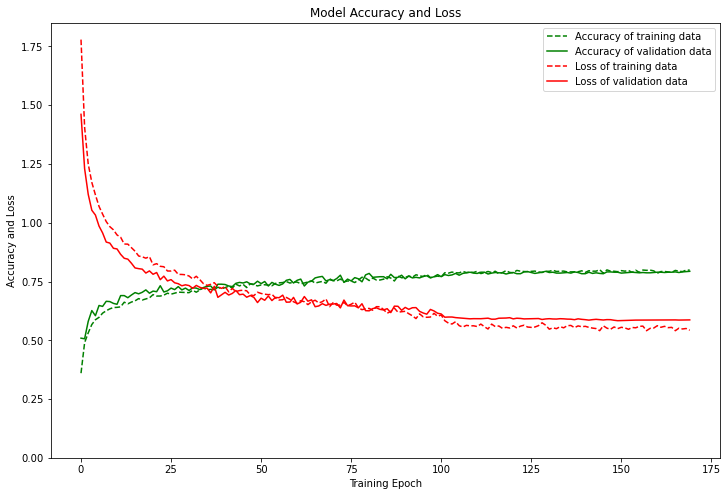

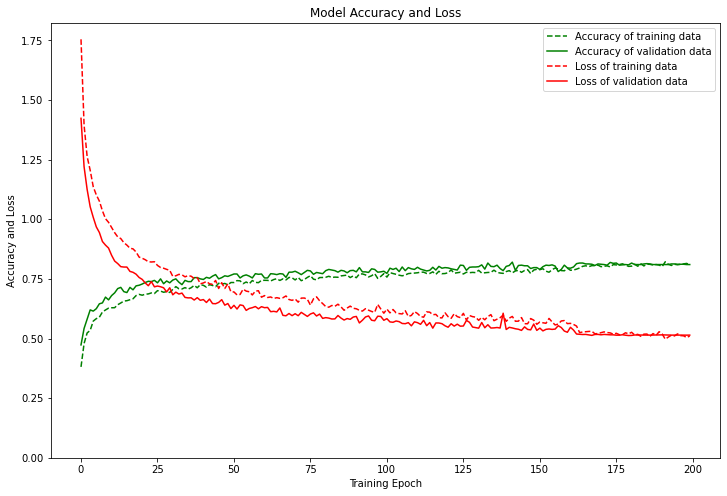

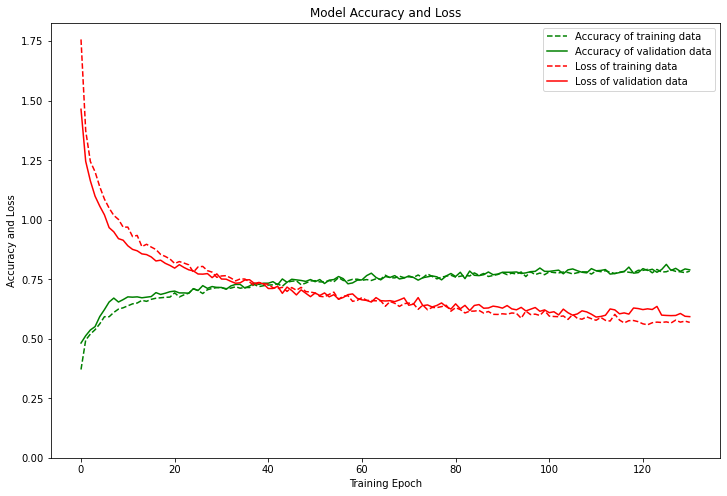

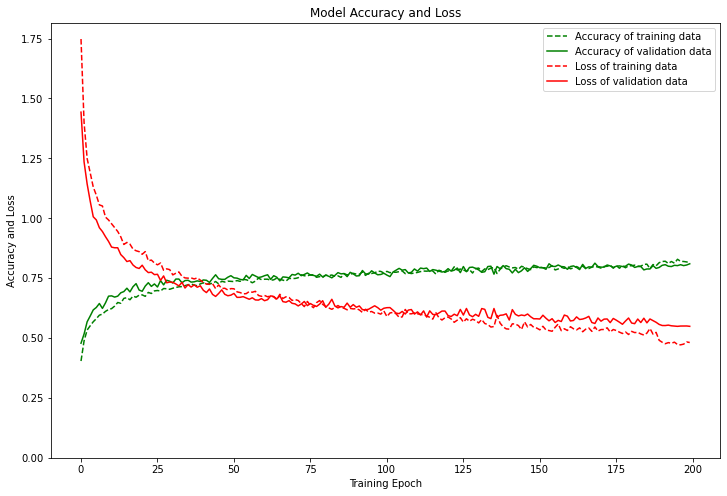

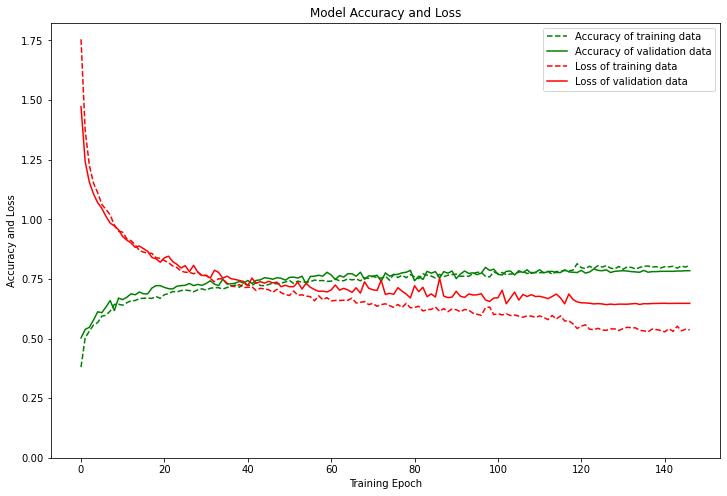

In [20]:
for history in train_histories:
    plt.figure(figsize=(12, 8))
    plt.plot(history['accuracy'], "g--", label="Accuracy of training data")
    plt.plot(history['val_accuracy'], "g", label="Accuracy of validation data")
    plt.plot(history['loss'], "r--", label="Loss of training data")
    plt.plot(history['val_loss'], "r", label="Loss of validation data")
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()